In [3]:
import pandas as pd
from numpy import load
import matplotlib.pyplot as plt
from numpy import save
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from keras.utils import normalize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [6]:
!gdown 1-FuNH_VEkltxgD_6NaEtZJQR7ABtEJeu

Downloading...
From: https://drive.google.com/uc?id=1-FuNH_VEkltxgD_6NaEtZJQR7ABtEJeu
To: /content/Final_masks.npy
100% 1.18G/1.18G [00:07<00:00, 163MB/s]


In [7]:
!gdown 1-JvSo_TegFO37CKFsv7zMuCaLIlthq7u

Downloading...
From: https://drive.google.com/uc?id=1-JvSo_TegFO37CKFsv7zMuCaLIlthq7u
To: /content/Final_images1.npy
100% 1.18G/1.18G [00:05<00:00, 210MB/s]


In [8]:
trainX, valX, trainY, valY = train_test_split(np.expand_dims(np.load('/content/Final_images1.npy'),axis=3),np.load('/content/Final_masks.npy'), test_size=0.20, random_state=42)

In [9]:
masks_cat=0
masks_cat_test=0

In [10]:
trainX.shape

(7200, 128, 128, 1, 1)

In [11]:
from keras.utils import to_categorical

In [12]:
masks_cat=to_categorical(trainY, num_classes= 4)

Validation masks from 0 to 1000 using one hot encoding 

In [13]:
masks_cat_val=to_categorical(valY[0:1000], num_classes=4)

Test data masks from 1000 to the end(1350) 

In [14]:
masks_cat_test=to_categorical(valY[1000::], num_classes=4)

In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    model.summary()
    
    return model

In [16]:



IMG_HEIGHT = trainX.shape[1]
IMG_WIDTH  = trainX.shape[2]
IMG_CHANNELS = trainX.shape[3]



metrics=['accuracy', jacard_coef]

In [17]:
model =  multi_unet_model(  n_classes=4, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
history1 = model.fit( trainX, masks_cat, 
                    batch_size = 64, 
                    
                    epochs=25, 
                    validation_data=(valX[0:1000], masks_cat_val), shuffle=False)

Epoch 1/25
113/113 [==============================] - 36s 202ms/step - loss: 0.2233 - accuracy: 0.9373 - jacard_coef: 0.8243 - val_loss: 0.1350 - val_accuracy: 0.9601 - val_jacard_coef: 0.8654
Epoch 2/25
113/113 [==============================] - 19s 169ms/step - loss: 0.1266 - accuracy: 0.9593 - jacard_coef: 0.8855 - val_loss: 0.1266 - val_accuracy: 0.9601 - val_jacard_coef: 0.8921
Epoch 3/25
113/113 [==============================] - 19s 169ms/step - loss: 0.1151 - accuracy: 0.9593 - jacard_coef: 0.8933 - val_loss: 0.1141 - val_accuracy: 0.9602 - val_jacard_coef: 0.8979
Epoch 4/25
113/113 [==============================] - 19s 168ms/step - loss: 0.1061 - accuracy: 0.9609 - jacard_coef: 0.9000 - val_loss: 0.1046 - val_accuracy: 0.9633 - val_jacard_coef: 0.9082
Epoch 5/25
113/113 [==============================] - 19s 168ms/step - loss: 0.0971 - accuracy: 0.9651 - jacard_coef: 0.9072 - val_loss: 0.0952 - val_accuracy: 0.9658 - val_jacard_coef: 0.9137
Epoch 6/25
113/113 [===============

In [ ]:
hist_df1 = pd.DataFrame(history1.history)
hist_df1.to_csv('history1.csv')
hist_df1

,loss,accuracy,jacard_coef,val_loss,val_accuracy,val_jacard_coef
0,0.223284,0.937274,0.824326,0.135024,0.960108,0.865368
1,0.126553,0.959252,0.885451,0.126582,0.960108,0.892149
2,0.115139,0.959274,0.893323,0.114057,0.960159,0.897873
3,0.106098,0.960915,0.900000,0.104633,0.963318,0.908193
4,0.097105,0.965110,0.907180,0.095247,0.965769,0.913740
5,0.085376,0.968332,0.915742,0.082357,0.970419,0.923180
6,0.075699,0.972769,0.924427,0.069489,0.975308,0.929658
7,0.067024,0.976028,0.932797,0.062665,0.977670,0.935359
8,0.060913,0.978147,0.938506,0.056766,0.979627,0.940854
9,0.056218,0.979787,0.942911,0.051768,0.981500,0.946867


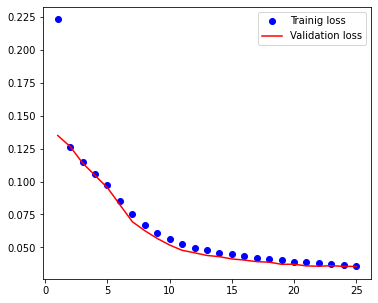

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']



epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

# loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(valX[0:1000],masks_cat_val)

32/32 [==============================] - 1s 40ms/step - loss: 0.0357 - accuracy: 0.9871 - jacard_coef: 0.9635


[0.035724490880966187, 0.9870994687080383, 0.9634848833084106]

1/1 [==============================] - 1s 739ms/step


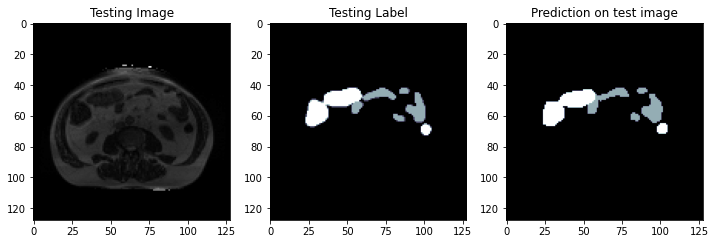

In [21]:
import random

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[0], axis=2), cmap='bone')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')
plt.show()
# test_img_number+=1


1/1 [==============================] - 0s 84ms/step


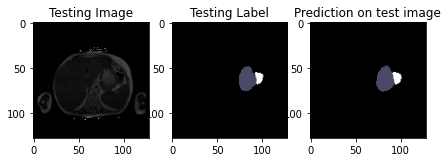

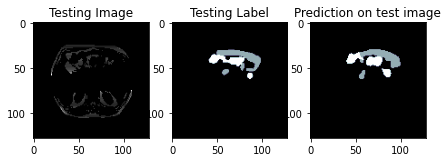

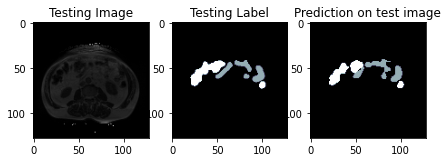

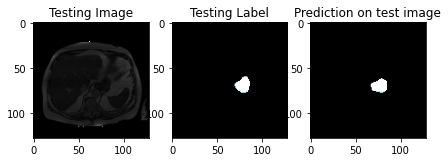

In [34]:
import random

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(251)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(252)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[test_img_number], axis=2), cmap='bone')
plt.subplot(253)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(151)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(152)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[test_img_number], axis=2), cmap='bone')
plt.subplot(153)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(351)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(352)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[test_img_number], axis=2), cmap='bone')
plt.subplot(353)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(351)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(352)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[test_img_number], axis=2), cmap='bone')
plt.subplot(353)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')
plt.show()

1/1 [==============================] - 0s 189ms/step


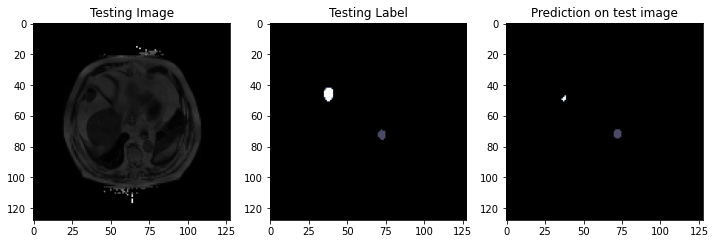

In [24]:
import random

test_img_number = random.randrange(0,350,1)
test_img = valX[1000+test_img_number]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[test_img_number], axis=2), cmap='bone')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')